In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [261]:
data = pd.read_csv('coding_round_data.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [262]:
# This is the proportion of positive class labels
data['Revenue'].mean()

0.15474452554744525

In [263]:
from sklearn.model_selection import StratifiedShuffleSplit
SEED = 12345 # To ensure we don't leak data between RAM resets (like shutting off my computer)
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = SEED)
train, test = list( splitter.split(X = data, y = data['Revenue']) )[0]

In [264]:
# To make sure the proportions of positive class labels in train, test are the same
np.isclose(data.iloc[test,:]['Revenue'].mean(), data.iloc[train,:]['Revenue'].mean(), atol = .001)

True

In [265]:
train_data = data.iloc[train,:]
test_data = data.iloc[test,:]

In [266]:
train_data['Month'].value_counts()
# Looks like there are only 10 months reported. We will start by encoding the months variable so that 
# the months are circular, and our feature will include information that December is closer to January
# than June. We can make it circular by replacing the Month value with the cosine & sine of the month's
# proportional distance between 0 and 2pi (ex. Jan=0=2pi, Dec=11pi/6=2pi-pi/12)

May     2675
Nov     2407
Mar     1532
Dec     1365
Oct      439
Jul      361
Sep      350
Aug      342
June     241
Feb      152
Name: Month, dtype: int64

In [267]:
class Pipeline:
    def __init__(self, *funcs):
        '''
            Desc:
                Takes in a list of functions & applies them to any pd.DataFramem passed
                in through the __call__ method.
            Args:
                *funcs: A list of functions
        '''
        self.funcs = list([func.__name__, func] for func in funcs)
    
    def __call__(self, dataframe):
        for funcname, func in self.funcs:
            print("Applying func", funcname)
            dataframe = func(dataframe)
        return dataframe
    
    def add(self, func):
        self.funcs.append( (func.__name__, func) )
    
    def __str__(self):
        return "Pipeline: " + ', '.join(funcname for funcname, _ in self.funcs)

pipeline = Pipeline()

In [268]:
def make_months_circular(df):
    months_map = dict(
        zip(
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            np.linspace(0,2*np.pi-2*np.pi/12,12)
        )
    )
    months_radian = df['Month'].apply(lambda month : months_map[month])
    months_x, months_y = np.cos(months_radian), np.sin(months_radian)
    df_updated = df.drop('Month', axis=1)
    df_updated['Month_x'] = months_x
    df_updated['Month_y'] = months_y
    return df_updated
train_data = make_months_circular(train_data)
pipeline.add(make_months_circular)

In [269]:
# We now check the data types to see if any types need changing (int -> categorical, etc)
train_data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
Month_x                    float64
Month_y                    float64
dtype: object

In [270]:
# We see that some of the data types still need some changing. (1, 2) as integers are different 
# from (1, 2) as categories (unordered).

def make_data_categorical(df):
    df[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']] = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']].astype('category')
    return df

make_data_categorical(train_data)
pipeline.add(make_data_categorical)

In [271]:
train_data.dtypes

# We can see now that the data types for the wrongly int-casted data types are fixed as categorical

Administrative                int64
Administrative_Duration     float64
Informational                 int64
Informational_Duration      float64
ProductRelated                int64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
PageValues                  float64
SpecialDay                  float64
OperatingSystems           category
Browser                    category
Region                     category
TrafficType                category
VisitorType                category
Weekend                        bool
Revenue                        bool
Month_x                     float64
Month_y                     float64
dtype: object

<AxesSubplot:>

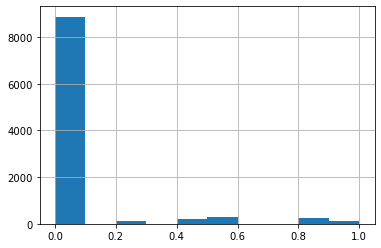

In [272]:
# Now I will do some final checking up on some of the other features of interest.
train_data['SpecialDay'].hist()

In [273]:
train_data['SpecialDay'].value_counts()
# Since SpecialDay has a fixed number of values, we will look at proportions of buys given the date falls
# on a day with the given SpecialDay value

0.0    8868
0.6     274
0.8     252
0.4     200
0.2     140
1.0     130
Name: SpecialDay, dtype: int64

In [274]:
train_data.groupby(['SpecialDay'])['Revenue'].mean()
# It initially seems like the proportion of buys given proximity to a special date goes down 
# compared to not having a special day coming up. There is a Region variable. We can test if these 
# "Special Days" are special in only some regions (ie. Diwali or Chinese New Year may not be as 
# special/popular in America as they are in their respective regions of origin.)

SpecialDay
0.0    0.164975
0.2    0.064286
0.4    0.055000
0.6    0.087591
0.8    0.039683
1.0    0.069231
Name: Revenue, dtype: float64

In [275]:
train_data.groupby(['Region', 'SpecialDay'])['Revenue'].mean()
# It looks like we get mixed results for whether a region considers a day "Special". Without knowing
# the actual special days (knowing whether the day is halloween, Chinese New Year, etc.) and regions,
# it will likely be better to just leave as is and use regularization down the line. Another problem
# is that as we group by more variables, we get smaller sample sizes, so I want to avoid being
# overconfident at this level.

Region  SpecialDay
1       0.0           0.178198
        0.2           0.017241
        0.4           0.028169
        0.6           0.076271
        0.8           0.009804
        1.0           0.125000
2       0.0           0.172414
        0.2           0.125000
        0.4           0.142857
        0.6           0.238095
        0.8           0.071429
        1.0           0.071429
3       0.0           0.157522
        0.2           0.032258
        0.4           0.000000
        0.6           0.033898
        0.8           0.108696
        1.0           0.030303
4       0.0           0.154299
        0.2           0.083333
        0.4           0.000000
        0.6           0.208333
        0.8           0.000000
        1.0           0.000000
5       0.0           0.152466
        0.2           0.000000
        0.4           0.142857
        0.6           0.000000
        0.8           0.000000
        1.0           0.000000
6       0.0           0.136752
        0.2         

In [277]:
test_data = pipeline(test_data)
# This cell just checks if the pipeline class works, which it does. We will now move to model selection.

Applying func make_months_circular
Applying func make_data_categorical


In [370]:
c = train_data[['VisitorType']].copy()

In [342]:
c['new'] = c['VisitorType'].cat.codes.astype('category')

In [372]:
c['new2'] = c['VisitorType'].apply(lambda row : cat_to_codes[row])

In [346]:
isinstance(c['new'].dtype, pd.CategoricalDtype)

True

In [364]:
codes_to_cat = dict( list(enumerate(c['VisitorType'].cat.categories ) ) )
cat_to_codes = dict( ( (value, key) for key, value in codes_to_cat.items() ) )

In [397]:
from joblib import load, dump
def nonnumeric_to_categorical_numeric(df):
    conversions = []
    def convert(col):
        nonlocal conversions
        if isinstance(col.dtype, pd.CategoricalDtype):
            codes_to_cat = dict( list(enumerate(col.cat.categories ) ) )
            cat_to_codes = dict( ( (value, key) for key, value in codes_to_cat.items() ) )
            conversions.append( {
                'name' : col.name, 
                'codes_to_cat' : codes_to_cat, 
                'cat_to_codes' : cat_to_codes
            })
            col = col.apply(lambda row : cat_to_codes[row])
        return col
    updated_df = df.apply(convert, axis=0)
    dump(updated_df, './metadata/conversions.final')
    return updated_df
        
train_data = nonnumeric_to_categorical_numeric(train_data)

In [404]:
clf = XGBClassifier( tree_method = 'hist',
 enable_categorical=True, use_label_encoder=False
)
clf.fit(train_data.drop('Revenue', axis=1), train_data['Revenue'])

ValueError: Experimental support for categorical data is not implemented for current tree method yet.

In [400]:
reg = XGBRegressor(enable_categorical=True)
reg.fit(train_data.drop('Revenue', axis=1), train_data['Revenue'])

ValueError: Experimental support for categorical data is not implemented for current tree method yet.

In [295]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import XGBClassifier, XGBRegressor

In [296]:
gscv = GridSearchCV(
    estimator = XGBRegressor(n_jobs = -1, objective = 'reg:squarederror', enable_categorical=True),
    param_grid = {
        'max_depth'     : [3,4],
        'learning_rate' : [.001, .01],
        'n_estimators'  : [200,300,400]
    },
    scoring = make_scorer(roc_auc_score),
    n_jobs = -1,
    verbose = 10,
    cv = 7,
    return_train_score = True
)

In [297]:
gscv.fit(train_data.drop('Revenue', axis=1), train_data['Revenue'])

Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0628s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1985s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished


ValueError: Experimental support for categorical data is not implemented for current tree method yet.